# CellRank pipeline, time series datasets (Waddington Optimal Transport)

## Import packages and set up the analysis

In [1]:
import sys

# the installation can take ~10mins
# ignore the messages: ERROR: Failed building wheel for <package>
# as long as it later print: Running setup.py install for <package> ... done
if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/theislab/cellrank@dev#egg=cellrank[external,krylov]

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import CellRank kernels and estimators
from cellrank.external.kernels import WOTKernel
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.estimators import GPCCA

In [3]:
# set verbosity levels
cr.settings.verbosity = 2
scv.settings.verbosity = 3

In [4]:
ROOT_FOLDER_H5AD = "/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/lineageInference/inputData/h5adObjects"
ROOT_FOLDER_TABLES = "/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/lineageInference/inputData/tables"

BASEANALYSIS = "/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/lineageInference/ciml5"
if not os.path.exists(BASEANALYSIS):
    os.mkdir(BASEANALYSIS)
    
h5adObjects = os.path.join(BASEANALYSIS,'h5ad.objects')
if not os.path.exists(h5adObjects):
    os.mkdir(h5adObjects)
    
sc.settings.figdir = os.path.join(BASEANALYSIS, "figures")
sc.settings.cachedir = os.path.join(BASEANALYSIS, "cache")
scv.settings.figdir = os.path.join(BASEANALYSIS, "figures")

In [5]:
# color table
colors_transferred_df = pd.read_csv(os.path.join(ROOT_FOLDER_TABLES,'clusterColors.tsv'),sep='\t')
colors_transferred_dic = colors_transferred_df.set_index('transferred_identity').to_dict()['blind_friendly']
colors_days_dic = {'Day_04': "#bb573b", 'Day_05': "#ac9d3e", 'Day_06': "#5aaf6a", 'Day_11': "#b94c84"}

In [6]:
analysis = "lab_4_days"
ANALYSIS_FOLDER = os.path.join(BASEANALYSIS, analysis)
if not os.path.exists(ANALYSIS_FOLDER):
    os.mkdir(ANALYSIS_FOLDER)
label_days = "days 4-5-6-11"

## Load the data

In [7]:
##rdsObjects = os.path.join(root_folder_h5ad, "rdsObjects")
#sepDays = ["lab_day_04", "lab_day_05", "lab_day_06", "lab_day_11"]
#sepData = ["07_clusters_" + aDay + ".h5ad" for aDay in sepDays]
#sepDataList = [sc.read_h5ad(os.path.join(root_folder_h5ad, aDay)) for aDay in sepData]

In [8]:
adata = sc.read_h5ad(os.path.join(ROOT_FOLDER_H5AD, '00_rawData_filtered_lab_4_days.h5ad'))


In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [10]:
#scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
#scv.pp.log1p(adata)

In [11]:
# umap coordinates
DR2d = pd.read_csv("/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/seuratAnalysis/ciml5/lab_4_days_merged/final_umap2Dcoordinates_lab_4_days_merged.csv", sep=",", index_col=0)
UMAP2d = DR2d.loc[adata.obs.index,[x for x in DR2d.columns.tolist() if "UMAP2d" in x]]
DR3d = pd.read_csv("/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/seuratAnalysis/ciml5/lab_4_days_merged/final_umap3Dcoordinates_lab_4_days_merged.csv", sep=",", index_col=0)
UMAP3d = DR3d.loc[adata.obs.index,[x for x in DR3d.columns.tolist() if "UMAP3d" in x]]
adata.obsm['X_umap2d'] = UMAP2d.to_numpy(dtype="float32")
adata.obsm['X_umap3d'] = UMAP3d.to_numpy(dtype="float32")

In [12]:
adata.obs.rename_axis('cellNames')

orig.ident  nCount_RNA  nFeature_RNA
cellNames                                                          
lab_day_04_1_AAACCCAAGTACAGAT  lab_4_days     59952.0          6798
lab_day_04_1_AAACCCAAGTTCATCG  lab_4_days     38805.0          5932
lab_day_04_1_AAACCCACAAGCGAAC  lab_4_days     45520.0          6008
lab_day_04_1_AAACCCACAAGGTTGG  lab_4_days     26325.0          4495
lab_day_04_1_AAACCCACACATATGC  lab_4_days     28761.0          4952
...                                   ...         ...           ...
lab_day_11_1_TTTGTTGAGGTAGATT  lab_4_days     21741.0          4056
lab_day_11_1_TTTGTTGAGGTGAGCT  lab_4_days      8956.0          2818
lab_day_11_1_TTTGTTGCAATATCCG  lab_4_days      9959.0          2919
lab_day_11_1_TTTGTTGGTAGACAGC  lab_4_days      7236.0          2180
lab_day_11_1_TTTGTTGTCAAAGGTA  lab_4_days      7669.0          2384

[26658 rows x 3 columns]

In [13]:
adata.obs = adata.obs.rename_axis('cellNames')
adata.obs['day'] = ['_'.join(x.split('_')[1:3]).capitalize() for x in adata.obs.index]

In [14]:
adata.obs.head()

orig.ident  nCount_RNA  nFeature_RNA     day
cellNames                                                                  
lab_day_04_1_AAACCCAAGTACAGAT  lab_4_days     59952.0          6798  Day_04
lab_day_04_1_AAACCCAAGTTCATCG  lab_4_days     38805.0          5932  Day_04
lab_day_04_1_AAACCCACAAGCGAAC  lab_4_days     45520.0          6008  Day_04
lab_day_04_1_AAACCCACAAGGTTGG  lab_4_days     26325.0          4495  Day_04
lab_day_04_1_AAACCCACACATATGC  lab_4_days     28761.0          4952  Day_04

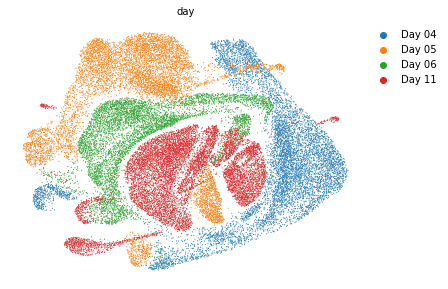

In [15]:
scv.pl.scatter(adata, basis="umap2d", c='day')

## Preprocess the data

In [16]:

#sc.pp.pca(adata)
#sc.pp.neighbors(adata, random_state=0)
#adata

In [17]:
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=17)
adata

AnnData object with n_obs × n_vars = 26658 × 22323
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'day_colors', 'hvg', 'pca', 'neighbors'
    obsm: 'X_umap2d', 'X_umap3d', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

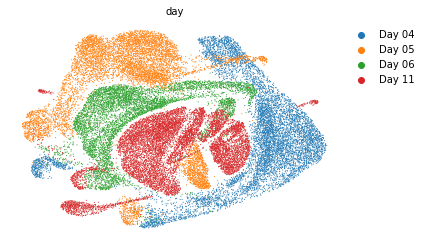

In [18]:
scv.pl.scatter(adata, basis="umap2d", c="day")

## Estimate initial growth rates

In [19]:
adata.obs['stage'] = adata.obs['day'].str[-2:].astype(int)
adata.obs.stage.head()

cellNames
lab_day_04_1_AAACCCAAGTACAGAT    4
lab_day_04_1_AAACCCAAGTTCATCG    4
lab_day_04_1_AAACCCACAAGCGAAC    4
lab_day_04_1_AAACCCACAAGGTTGG    4
lab_day_04_1_AAACCCACACATATGC    4
Name: stage, dtype: int64

In [20]:
wk = WOTKernel(adata, time_key="stage")

In [21]:
#wk.compute_initial_growth_rates(organism="mouse", key_added="growth_rate_init")

In [22]:
#prolif_genes = ['Mcm4', 'Smc4', 'Gtse1', 'Ttk', 'Rangap1', 'Ccnb2', 'Cenpa', 'Cenpe', 'Cdca8', 'Ckap2', 'Rad51', 'Pcna', 'Ube2c', 'Lbr', 'Cenpf', 'Birc5', 'Dtl', 'Dscc1', 'Cbx5', 'Usp1', 'Hmmr', 'Wdr76', 'Ung', 'Hn1', 'Cks2', 'Kif20b', 'Cdk1', 'Slbp', 'Aurkb', 'Kif11', 'Cks1b', 'Blm', 'Msh2', 'Gas2l3', 'Tyms', 'Hjurp', 'Hells', 'Prim1', 'Uhrf1', 'Ndc80', 'Mcm6', 'Rrm1', 'Mlf1ip', 'Top2a', 'Hmgb2', 'Ccne2', 'G2e3', 'Tmpo', 'Nusap1', 'Ncapd2', 'Mcm2', 'Kif2c', 'Cdca2', 'Nasp', 'Gmnn', 'Cdc6', 'Pold3', 'Ckap2l', 'Fam64a', 'Ubr7', 'Fen1', 'Bub1', 'Brip1', 'Atad2', 'Psrc1', 'Rrm2', 'Tipin', 'Casp8ap2', 'Tubb4b', 'Kif23', 'Exo1', 'Rfc2', 'Pola1', 'Mki67', 'Tpx2', 'Aurka', 'Anln', 'Chaf1b', 'Hjurp', 'Tacc3', 'Mcm5', 'Anp32e', 'Dlgap5', 'Ect2', 'Nuf2', 'Cdc45', 'Ckap5', 'Ctcf', 'Clspn', 'Cdca7', 'Cdca3', 'Rpa2', 'Gins2', 'E2f8', 'Cdc25c', 'Nek2', 'Cdc20', 'Rad51ap1']
#availGenes = [gene for gene in prolif_genes if gene in adata.var_names ]
#print(str(len(availGenes)) + " proliferation genes over the " + str(len(prolif_genes)) + " provided.")
#availGenes

I'm not able to use the proliferation genes provided by the kernel WOT. I still continue the analysis as it is mentioned in the tutorial of the tool:

> Notes
> 
> If you don’t have access to proliferation/apoptosis gene sets, you can use the ones defined in cellrank for a specific organism. Alternatively, you can also use WOT without an estimate of initial growth rates. In that case, make sure to use several iterations in cellrank.external.kernels.WOTKernel.compute_transition_matrix() by increasing the growth_iters parameter. A value around 3 works well in most cases.

In [23]:
#scv.pl.scatter(
#    adata, c="growth_rate_init", legend_loc="right", basis="umap_2d", s=10
#)

## Compute transition matrix

In [24]:
wk.compute_transition_matrix(
    growth_iters=3, last_time_point="connectivities"
)

Computing transition matrix using Waddington optimal transport
Using `2275` HVGs from `adata.var['highly_variable']`
Using default cost matrices
Computing transport maps for `3` time pairs


  0%|          | 0/3 [00:00<?, ?time pair/s]

    Finish (0:09:26)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Using `threshold=0.0014307014642096576`
    Finish (0:09:57)


<WOTKernel>

## Simulate random walks

Simulating `100` random walks of maximum length `50`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks


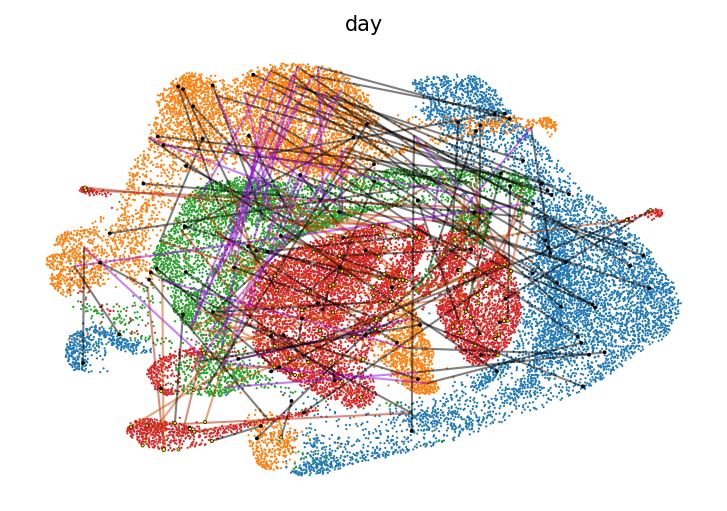

In [25]:
wk.plot_random_walks(
    n_sims=100,
    max_iter=50,
    stop_ixs={"stage": [11]},
    basis="umap2d",
    c="day",
    legend_loc="none",
    linealpha=0.5,
    dpi=150,
    seed=17,
    n_jobs=8
)

Following code chunk starts the random walks from the stage 4 (ie. day4).

In [26]:
wk.plot_random_walks(
    n_sims=100,
    max_iter=50,
    start_ixs={"stage": [4]},
    basis="umap2d",
    c="day",
    legend_loc="none",
    linealpha=0.5,
    dpi=150,
    seed=17,
    n_jobs=8
)

Simulating `100` random walks of maximum length `50`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:00)
Plotting random walks


### Addition of celltype and cluster information of each cells

In [27]:
# multi time-point information
multiTPmetadata = pd.read_csv("/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/seuratAnalysis/ciml5/lab_4_days_merged/metadata_celltypeANDclusters_lab_4_days_merged.csv", sep=',')
adata.obs = adata.obs.join(multiTPmetadata)

# single time-point information
for dataset in ["lab_day_04", "lab_day_05", "lab_day_06", "lab_day_11"]:
    if "singleTPmetadata" not in globals():
        singleTPmetadata = pd.read_csv("/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/seuratAnalysis/ciml5/" + dataset + "/metadata_celltypeANDclusters_" + dataset + ".csv", sep=",")
    else:
        additionalMD = pd.read_csv("/mnt/DATA_4TB/projects/gastruloids_sc_Lescroart/analysis/seuratAnalysis/ciml5/" + dataset + "/metadata_celltypeANDclusters_" + dataset + ".csv", sep=",")
        singleTPmetadata = pd.concat([singleTPmetadata, additionalMD])

singleTPmetadata.drop(['celltype_DF'], axis=1, inplace=True)
singleTPmetadata.head()

adata.obs = adata.obs.join(singleTPmetadata)
adata.obs['multiTP_res1'] = adata.obs['multiTP_res1'].astype('category')
adata.obs['multiTP_celltype'] = adata.obs['multiTP_celltype'].astype('category')
adata.obs['singleTP_res1'] = adata.obs['singleTP_res1'].astype('category')
adata.obs['singleTP_celltype'] = adata.obs['singleTP_celltype'].astype('category')
adata.obs.head()

adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 26658 × 22323
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day', 'stage', 'estimated_growth_rates', 'multiTP_celltype', 'multiTP_res1', 'singleTP_celltype', 'singleTP_res1'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'day_colors', 'hvg', 'pca', 'neighbors', 'stage_colors'
    obsm: 'X_umap2d', 'X_umap3d', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'>

In [39]:
# create dataframe to plot
df1 = pd.DataFrame(adata.obsm['X_umap2d'], index=adata.obs.index, columns=['UMAP_1', 'UMAP_2'])
#df1 = pd.DataFrame(adata.obsm['X_umap3d'], index=adata.obs.index, columns=['UMAP_1', 'UMAP_2', 'UMAP_3'])
df2 = pd.DataFrame(adata.obs)
#df3 = pd.DataFrame(adata.obs['ct_scmapAtlas'], index=adata.obs.index, columns=['ct_scmapAtlas'])
df = pd.concat([df1,df2], axis=1).sort_values(by = 'day')
#fig = px.scatter_3d(df, x="UMAP_1", y="UMAP_2", z="UMAP_3",
#    color="day",
#    hover_name='singleTP.celltype', color_discrete_sequence=['dodgerblue','orange','green','red'],
#    height=1500, title="Complete dataset over " + label_days + " -- coloration by day")
#fig
fig = px.scatter(df, x="UMAP_1", y="UMAP_2", color="day",
    hover_name='singleTP_celltype',
    color_discrete_sequence=['dodgerblue','orange','green','red'],
    height=1500,
    title="Complete dataset over " + label_days + " -- coloration by day",
    hover_data={
        'UMAP_1':False,
        'UMAP_2':False,
        'day':True,
        'singleTP_res1':True,
        'multiTP_res1':True
    }
)
fig

Simulating `50` random walks of maximum length `20`


  0%|          | 0/50 [00:00<?, ?sim/s]

    Finish (0:00:00)
Plotting random walks
Simulating `1` random walks of maximum length `6665`


  0%|          | 0/1 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks


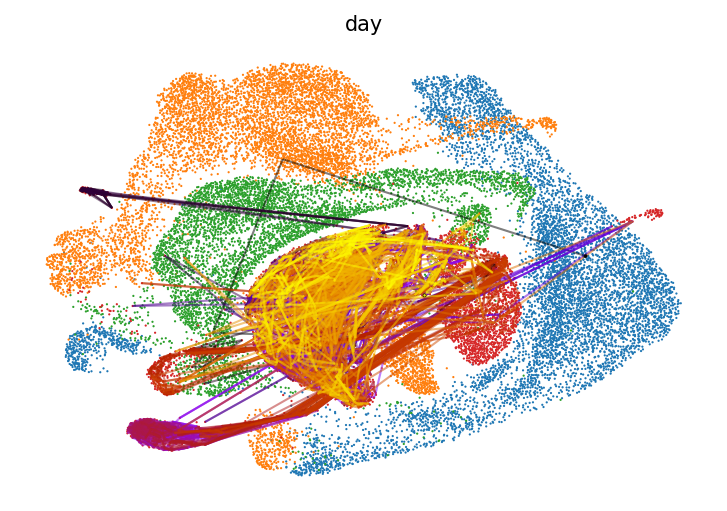

In [29]:
wk.plot_random_walks(
    n_sims=50,
    max_iter=20,
    start_ixs={"singleTP_celltype": ["Epiblast"]},
    basis="umap2d",
    c="day",
    legend_loc="none",
    linealpha=0.5,
    dpi=150
)

wk.plot_random_walks(
    n_sims=1,
    start_ixs={"day": ["Day_04"]},
    basis="umap2d",
    c="day",
    legend_loc="none",
    linealpha=0.5,
    dpi=150
)

In [30]:
wk.plot_random_walks(
    n_sims=1,
    max_iter=0.1,
    start_ixs={"multiTP_celltype": ["Epiblast"]},
    stop_ixs={"multiTP_res1": ["27"]},
    successive_hits=2,
    basis="umap2d",
    c="day",
    legend_loc="none",
    linealpha=0.5,
    dpi=150
)

Simulating `1` random walks of maximum length `2666`


  0%|          | 0/1 [00:00<?, ?sim/s]

    Finish (0:00:01)
Plotting random walks


In [31]:
adata

AnnData object with n_obs × n_vars = 26658 × 22323
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day', 'stage', 'estimated_growth_rates', 'multiTP_celltype', 'multiTP_res1', 'singleTP_celltype', 'singleTP_res1'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'day_colors', 'hvg', 'pca', 'neighbors', 'stage_colors'
    obsm: 'X_umap2d', 'X_umap3d', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
copied = adata.copy
copied

<bound method AnnData.copy of AnnData object with n_obs × n_vars = 26658 × 22323
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day', 'stage', 'estimated_growth_rates', 'multiTP_celltype', 'multiTP_res1', 'singleTP_celltype', 'singleTP_res1'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'day_colors', 'hvg', 'pca', 'neighbors', 'stage_colors'
    obsm: 'X_umap2d', 'X_umap3d', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'>

In [33]:
copied = wk.write_to_adata()

In [34]:
copied

In [35]:
adata

AnnData object with n_obs × n_vars = 26658 × 22323
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day', 'stage', 'estimated_growth_rates', 'multiTP_celltype', 'multiTP_res1', 'singleTP_celltype', 'singleTP_res1'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'day_colors', 'hvg', 'pca', 'neighbors', 'stage_colors', 'T_fwd_params'
    obsm: 'X_umap2d', 'X_umap3d', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'T_fwd'

In the following code chunk the random walks should start from the epiblast of day 4 (cluster 'single.res1' equals to 4.9).

In [36]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 26658 × 22323
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'day', 'stage', 'estimated_growth_rates', 'multiTP_celltype', 'multiTP_res1', 'singleTP_celltype', 'singleTP_res1'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'day_colors', 'hvg', 'pca', 'neighbors', 'stage_colors', 'T_fwd_params'
    obsm: 'X_umap2d', 'X_umap3d', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'T_fwd'>

In [38]:
epiblast = adata.obs.singleTP_res1[adata.obs.multiTP_celltype == "Epiblast"].value_counts(ascending=False)
epiblast

4_9     133
5_14     25
5_11     22
6_16      5
5_6       4
       ... 
4_2       0
4_3       0
4_4       0
4_5       0
6_9       0
Name: singleTP_res1, Length: 65, dtype: int64

In [40]:
epiblast.loc[set(epiblast.index).intersection(set(clusterDay4))]


NameError: name 'clusterDay4' is not defined

In [ ]:
wk.plot_random_walks(
    n_sims=100,
    max_iter=10,
    start_ixs={'singleTP_res1': ['4.9']},
    basis="umap2d",
    c="day",
    legend_loc="none",
    linealpha=0.5,
    dpi=150,
)

## Probability mass flow in time

The cluster in title is the cluster for wich to visualize outgoing flow. The `min_flow` parameter is a bottom threshold to show flow edges with flow greater than this value.

In [ ]:
cluster_sort = adata.obs['single.res1'].cat.categories.astype('str').sort_values()
cluster_sort

In [ ]:
adata.obs_keys

In [ ]:
adata.obs['multiTP.res1'].cat.categories

In [ ]:
adata.obs.groupby('day')['multiTP.res1'].apply(lambda x: (x==9).sum()).reset_index(name='count')

In [ ]:
adata.obs.query('adata.obs["multiTP.res1"] == 9 & day == "Day_04"')

In [ ]:
adata.obs.groupby('day')['multiTP.res1'].apply(lambda x: (x==9).sum()).reset_index(name='count')

In [ ]:
cluster_sort = adata.obs['single.res1'].cat.categories

for clust in cluster_sort:
    ax = wk.plot_single_flow(
        cluster_key="single.res1",
        time_key="stage",
        cluster=clust,
        min_flow=0.05,
        show=False,
        dpi=100
    )

    # prettify the plot a bit, rotate x-axis tick labels
    locs, labels = plt.xticks()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels, rotation=45)

    plt.show()

## Compute macrostates

In [41]:
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * wk + 0.2 * ck

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [42]:
g = GPCCA(combined_kernel)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:05)


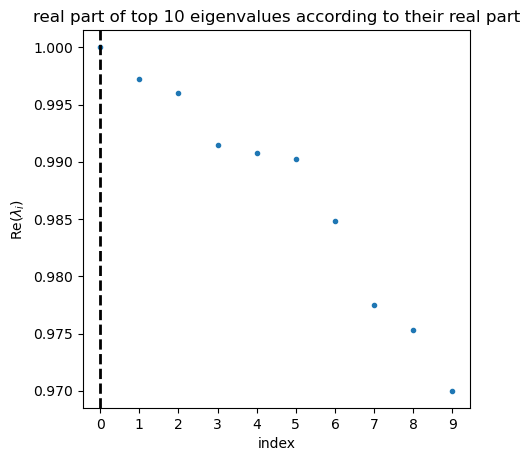

In [43]:
g.compute_schur()
g.plot_spectrum(real_only=True)

Computing `6` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:08)


/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



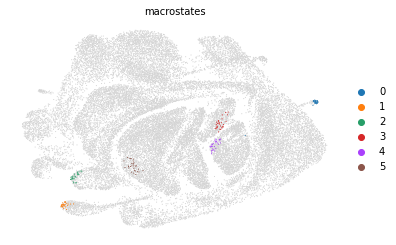

In [44]:
g.compute_macrostates(n_states=6)
g.plot_macrostates(discrete=True, basis="umap2d", legend_loc="right")

Computing `9` macrostates


/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:51)


/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



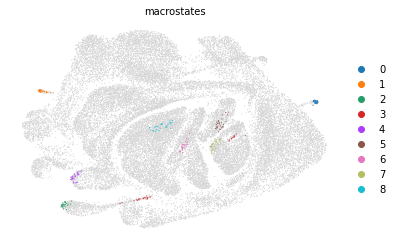

In [70]:
g.compute_macrostates(n_states=9)
g.plot_macrostates(discrete=True, basis="umap2d", legend_loc="right")

## Define terminal macrostates

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



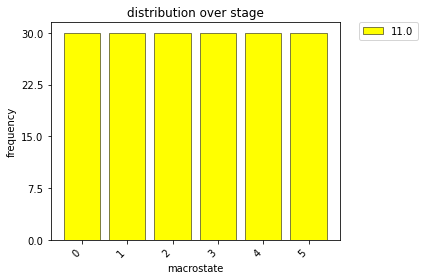

In [72]:
g.plot_macrostate_composition(key="stage")

In [46]:
terminal_clusters = g.macrostates.cat.categories
g.set_terminal_states_from_macrostates(terminal_clusters)

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


In [97]:
macro0 = adata.obs[adata.obs.terminal_states == '5']
macro0

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



orig.ident  nCount_RNA  nFeature_RNA     day  \
cellNames                                                                     
lab_day_11_1_AACAAGAGTCGTTATG  lab_4_days     11281.0          2843  Day_11   
lab_day_11_1_AAGAACATCCGAGCTG  lab_4_days      8440.0          2786  Day_11   
lab_day_11_1_ACAGGGACAGACGGAT  lab_4_days      5969.0          1907  Day_11   
lab_day_11_1_ACATTTCTCCTGCTAC  lab_4_days      9688.0          2996  Day_11   
lab_day_11_1_ACGTAACTCATAGACC  lab_4_days     10255.0          3084  Day_11   
lab_day_11_1_ACTTCGCCACTCATAG  lab_4_days     13987.0          3750  Day_11   
lab_day_11_1_AGCGATTTCGCTTACC  lab_4_days      4537.0          1700  Day_11   
lab_day_11_1_AGGTTACGTGTGATGG  lab_4_days      7239.0          2611  Day_11   
lab_day_11_1_AGTCAACGTTCTCCCA  lab_4_days     10316.0          2638  Day_11   
lab_day_11_1_CACATGAAGCACCTGC  lab_4_days      7794.0          2989  Day_11   
lab_day_11_1_CCAATTTAGTGGTTAA  lab_4_days     10410.0          3177  Day_11   
lab_day_11_1_CCGAACGCATGAGTAA  lab_4_days      8759.0          2832  Day_11   
lab_day_11_1_CCTAAGAAGTCTGGTT  lab_4_days      5893.0          2200  Day_11   
lab_day_11_1_CTCTGGTAGCTGAAAT  lab_4_days      8384.0          2692  Day_11   
lab_day_11_1_CTCTGGTGTCAGACTT  lab_4_days      7406.0          2741  Day_11   
lab_day_11_1_GCATCTCGTGGACCAA  lab_4_days      7675.0          2300  Day_11   
lab_day_11_1_GCATGATTCATGAGTC  lab_4_days     10994.0          2942  Day_11   
lab_day_11_1_GCCATTCTCTGAGATC  lab_4_days     10434.0          3105  Day_11   
lab_day_11_1_GGTAGAGCAATCGCAT  lab_4_days     10422.0          2916  Day_11   
lab_day_11_1_GTGACGCCAGGATCTT  lab_4_days     10100.0          3088  Day_11   
lab_day_11_1_GTGATGTTCATTGTTC  lab_4_days     10473.0          3224  Day_11   
lab_day_11_1_GTTCTATCAGTGCCTG  lab_4_days      4075.0          1599  Day_11   
lab_day_11_1_TATCGCCTCGCTTTAT  lab_4_days     10123.0          2871  Day_11   
lab_day_11_1_TATTCCACACCGTGCA  lab_4_days     10993.0          2825  Day_11   
lab_day_11_1_TATTTCGTCGAAGTGG  lab_4_days      6960.0          2260  Day_11   
lab_day_11_1_TCGGTCTGTGGGAGAG  lab_4_days      9613.0          2877  Day_11   
lab_day_11_1_TCTCACGAGCTACTGT  lab_4_days     20546.0          4176  Day_11   
lab_day_11_1_TGATCTTCAGCTGAGA  lab_4_days      8255.0          2387  Day_11   
lab_day_11_1_TGGGAAGCAGTCAGTT  lab_4_days      9567.0          2793  Day_11   
lab_day_11_1_TTGACCCTCTCGGCTT  lab_4_days      9047.0          2921  Day_11   

                              stage  estimated_growth_rates  \
cellNames                                                     
lab_day_11_1_AACAAGAGTCGTTATG  11.0                     NaN   
lab_day_11_1_AAGAACATCCGAGCTG  11.0                     NaN   
lab_day_11_1_ACAGGGACAGACGGAT  11.0                     NaN   
lab_day_11_1_ACATTTCTCCTGCTAC  11.0                     NaN   
lab_day_11_1_ACGTAACTCATAGACC  11.0                     NaN   
lab_day_11_1_ACTTCGCCACTCATAG  11.0                     NaN   
lab_day_11_1_AGCGATTTCGCTTACC  11.0                     NaN   
lab_day_11_1_AGGTTACGTGTGATGG  11.0                     NaN   
lab_day_11_1_AGTCAACGTTCTCCCA  11.0                     NaN   
lab_day_11_1_CACATGAAGCACCTGC  11.0                     NaN   
lab_day_11_1_CCAATTTAGTGGTTAA  11.0                     NaN   
lab_day_11_1_CCGAACGCATGAGTAA  11.0                     NaN   
lab_day_11_1_CCTAAGAAGTCTGGTT  11.0                     NaN   
lab_day_11_1_CTCTGGTAGCTGAAAT  11.0                     NaN   
lab_day_11_1_CTCTGGTGTCAGACTT  11.0                     NaN   
lab_day_11_1_GCATCTCGTGGACCAA  11.0                     NaN   
lab_day_11_1_GCATGATTCATGAGTC  11.0                     NaN   
lab_day_11_1_GCCATTCTCTGAGATC  11.0                     NaN   
lab_day_11_1_GGTAGAGCAATCGCAT  11.0                     NaN   
lab_day_11_1_GTGACGCCAGGATCTT  11.0                     NaN   
lab_day_11_1_GTGATGTTCATTGTTC  11.0                     NaN   
lab_day_11_1_GTTCTATCAGTGCCTG  11.0                  

## Compute fate probabilities

Computing absorption probabilities


/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



  0%|          | 0/6 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:05)


/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning:

The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.



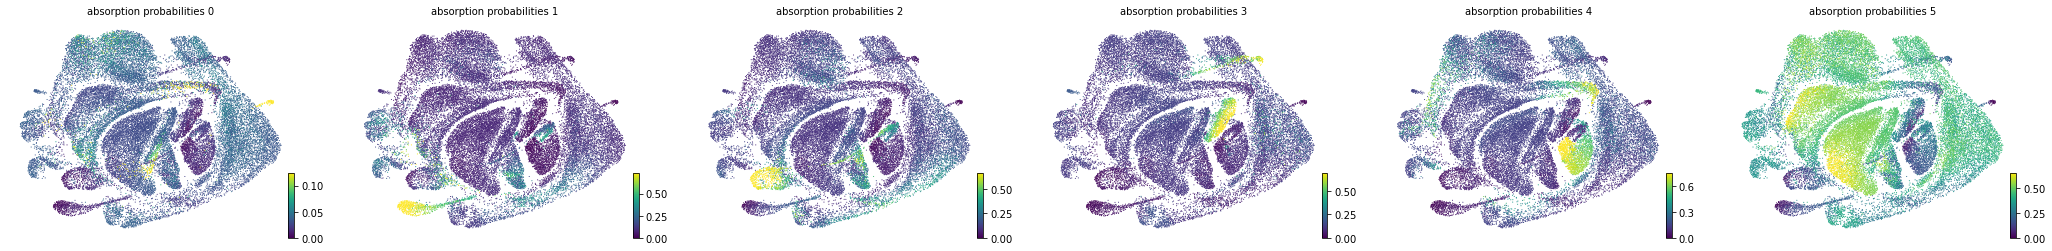

In [81]:
g.compute_absorption_probabilities(solver="gmres", use_petsc=True)
g.plot_absorption_probabilities(same_plot=False, basis="umap2d", perc=[0, 99])

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



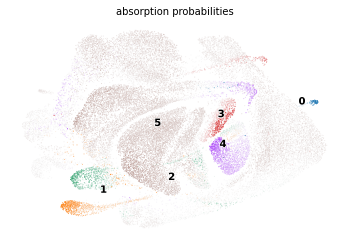

In [82]:
g.plot_absorption_probabilities(same_plot=True, basis="umap2d", perc=[0, 99])

In [ ]:
cr.pl.circular_projection(adata, keys=["stage"], legend_loc="none", title="")

## Log-odds in time

In [ ]:
adata

In [ ]:
#adata.obsm['']
print(terminal_clusters)

In [ ]:
for clust in terminal_clusters:
    cr.pl.log_odds(
        adata,
        lineage_1=clust,
        lineage_2=None,
        time_key="stage",
        threshold=0,
        size=2,
        figsize=(9, 4),
        legend_loc="upper right out",
    )

In [ ]:
cr.pl.log_odds(
    adata,
    lineage_1="7",
    lineage_2=None,
    time_key="stage",
    keys=["Mesp1", "Myog", "Myod1", "Pax3"],
    threshold=0,
    size=2,
    figsize=(9, 4),
    legend_loc="upper right out",
)

## Driver genes

In [83]:
g.compute_lineage_drivers(return_drivers=False)

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:07)


0_corr        0_pval  0_qval  0_ci_low  0_ci_high    1_corr  \
Myh3           0.782701  0.000000e+00     NaN  0.778007   0.787308 -0.037764   
Mymk           0.757822  0.000000e+00     NaN  0.752665   0.762886 -0.039553   
Mylk4          0.723200  0.000000e+00     NaN  0.717424   0.728877 -0.041963   
Tnnc2          0.710891  0.000000e+00     NaN  0.704902   0.716778 -0.042927   
Myog           0.689384  0.000000e+00     NaN  0.683032   0.695632 -0.038006   
...                 ...           ...     ...       ...        ...       ...   
Tnni3         -0.103118  4.864446e-64     NaN -0.114980  -0.091226 -0.162766   
Aplp1         -0.103118  4.856865e-64     NaN -0.114980  -0.091227  0.243694   
Crip2         -0.107692  1.007025e-69     NaN -0.119542  -0.095811 -0.037095   
Dpysl3        -0.107995  4.146191e-70     NaN -0.119844  -0.096115  0.288658   
9130016M20Rik       NaN           NaN     NaN       NaN        NaN       NaN   

                      1_pval  1_qval  1_ci_low  1_ci_high  ...    4_corr  \
Myh3            6.896638e-10     NaN -0.049746  -0.025771  ... -0.048872   
Mymk            1.040189e-10     NaN -0.051533  -0.027562  ... -0.047571   
Mylk4           7.126132e-12     NaN -0.053940  -0.029974  ... -0.040776   
Tnnc2           2.337705e-12     NaN -0.054903  -0.030938  ... -0.018934   
Myog            5.365042e-10     NaN -0.049988  -0.026014  ... -0.045586   
...                      ...     ...       ...        ...  ...       ...   
Tnni3          2.328639e-158     NaN -0.174429  -0.151057  ...  0.736972   
Aplp1           0.000000e+00     NaN  0.232370   0.254953  ...  0.094357   
Crip2           1.369614e-09     NaN -0.049077  -0.025102  ...  0.549389   
Dpysl3          0.000000e+00     NaN  0.277615   0.299624  ...  0.181294   
9130016M20Rik            NaN     NaN       NaN        NaN  ...       NaN   

                      4_pval  4_qval  4_ci_low  4_ci_high    5_corr  \
Myh3            1.400093e-15     NaN -0.060841  -0.036890 -0.112154   
Mymk            7.695743e-15     NaN -0.059541  -0.035587 -0.105508   
Mylk4           2.720524e-11     NaN -0.052755  -0.028786 -0.104286   
Tnnc2           1.990819e-03     NaN -0.030931  -0.006931 -0.109712   
Myog            9.497378e-14     NaN -0.057559  -0.033600 -0.088963   
...                      ...     ...       ...        ...       ...   
Tnni3           0.000000e+00     NaN  0.731439   0.742409 -0.353882   
Aplp1           7.428880e-54     NaN  0.082446   0.106241 -0.115094   
Crip2           0.000000e+00     NaN  0.540953   0.557716 -0.540438   
Dpysl3         8.134254e-197     NaN  0.169659   0.192878 -0.250578   
9130016M20Rik            NaN     NaN       NaN        NaN       NaN   

                     5_pval  5_qval  5_ci_low  5_ci_high  
Myh3           1.637913e-75     NaN -0.123992  -0.100285  
Mymk           5.597150e-67     NaN -0.117364  -0.093622  
Mylk4          1.813523e-65     NaN -0.116145  -0.092398  
Tnnc2          2.586936e-72     NaN -0.121556  -0.097836  
Myog           4.831206e-48     NaN -0.100860  -0.077041  
...                     ...     ...       ...        ...  
Tnni3          0.000000e+00     NaN -0.364338  -0.343336  
Aplp1          1.854416e-79     NaN -0.126923  -0.103233  
Crip2          0.000000e+00     NaN -0.548881  -0.531884  
Dpysl3         0.000000e+00     NaN -0.261795  -0.239293  
9130016M20Rik           NaN     NaN       NaN        NaN  

[22323 rows x 30 columns]

In [147]:
n_feat = 5

clust = "0"
top_0 = adata.varm['terminal_lineage_drivers'].filter(regex=(clust+"_corr")).sort_values(by=clust+"_corr", ascending=False).iloc[:n_feat].index[:].tolist()

clust = "4"
top_4 = adata.varm['terminal_lineage_drivers'].filter(regex=(clust+"_corr")).sort_values(by=clust+"_corr", ascending=False).iloc[:n_feat].index[:].tolist()

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [148]:
goi = {
    "0": top_0,
    "4": top_4
}

# compute mean gene expression across cells, so we have somethign nice to color the dots by
#adata.var["means"] = adata.X.A.mean(axis=0)

/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [145]:
goi

{'0': ['Myh3',
  'Mymk',
  'Mylk4',
  'Tnnc2',
  'Myog',
  'Mybph',
  'Neb',
  'Il17b',
  'Sgcg',
  'Klhl41',
  'Myod1',
  'Chrna1',
  'Ablim3',
  'Cdh15',
  'Gm28653',
  'Myot',
  'Cacng1',
  'Arpp21',
  'Klhl40',
  'Myh8'],
 '4': ['Cryab',
  'Hspb7',
  'Tnnc1',
  'Mybpc3',
  'Myh6',
  'Pgam2',
  'Csrp3',
  'Sh3bgr',
  'Hspb2',
  'Ryr2',
  'Myl7',
  'Cox6a2',
  'Myl4',
  'Tnni3',
  'Tnnt2',
  'Asb2',
  'Actc1',
  'Ldb3',
  'Ttn',
  'Atcayos']}

... storing 'orig.ident' as categorical


Adjusting text position


/opt/anaconda3/envs/veloRossi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:724: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



    Finish (0:00:02)


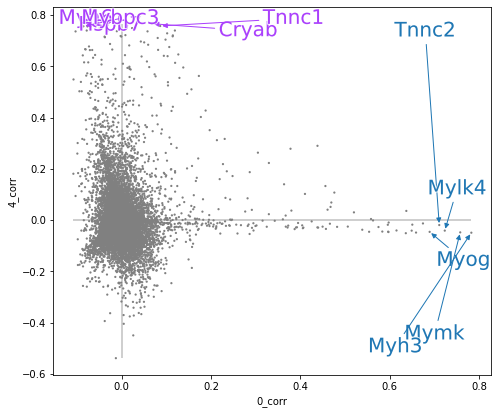

In [149]:
# call the actual plotting method via the estimator object
g.plot_lineage_drivers_correlation(
    lineage_x="0",
    lineage_y="4",
    gene_sets=goi,
    legend_loc="none",
    figsize=(7, 7),
    fontsize=20,
    title=["driver genes for 0 vs. 4 differentiation"],
    size=20,
    adjust_text=True
)